In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python numpy kagglehub

In [ ]:
!pip install tensorflow

In [ ]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import cv2
import numpy as np
import os
import kagglehub
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Lambda, Flatten, Dense


In [ ]:
from collections import defaultdict
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
K.set_image_data_format('channels_last')
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
path = kagglehub.dataset_download("ruizgara/socofing", force_download=True)
print("Dataset path:", path)
print("Root contents:", os.listdir(path))

Dataset path: /kaggle/input/socofing
Root contents: ['SOCOFing', 'socofing']


In [ ]:
def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_last', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_last')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_last', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def inception_block_1a(X):
    """
    Implementation of an inception block
    """

    X_3x3 = Conv2D(96, (1, 1), data_format='channels_last', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_last', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(16, (1, 1), data_format='channels_last', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_last', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_last')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    # CONCAT
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception


def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_last', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_last', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_last', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_last')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_last')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=-1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_last')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=-1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=-1)

    return inception

def imgRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet

    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)

    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = -1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = -1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)

    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)

    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)

    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)

    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_last')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)

    # L2 normalization
    X = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), output_shape=(128,))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='ImgRecoModel')

    return model

In [ ]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [ ]:
altered_path = os.path.join(path, "SOCOFing", "Altered")
real_path = os.path.join(path, "SOCOFing", "Real")

dic_alt_easy = get_data_dic(os.path.join(altered_path, "Altered-Easy"))
dic_alt_hard = get_data_dic(os.path.join(altered_path, "Altered-Hard"))
dic_alt_med = get_data_dic(os.path.join(altered_path, "Altered-Medium"))
dic_real = get_data_dic(real_path, train=False)

In [ ]:
def merge_data(dic1, dic2, dic3):

    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2

    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3

    return dic1

In [ ]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [ ]:
ids = list(dic_data.keys())
len(ids)

6000

In [ ]:
train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=42)
print(f"Training IDs: {len(train_ids)}, Testing IDs: {len(test_ids)}")

Training IDs: 4800, Testing IDs: 1200


In [ ]:
def get_batch_data(batch_size, ids, dic_data, dic_real):
    gen = get_train_data(ids, dic_data, dic_real)

    x1 = np.zeros((batch_size, 96, 96, 1), dtype='float32')
    x2 = np.zeros((batch_size, 96, 96, 1), dtype='float32')
    y = np.zeros((batch_size, 1), dtype='float32')

    while True:
        for i in range(0, batch_size, 2):
            anc_img, pos_img, neg_img = next(gen)

            x1[i] = anc_img
            x2[i] = pos_img
            y[i] = 1.0  # positive pair

            if i+1 < batch_size:
                x1[i+1] = anc_img
                x2[i+1] = neg_img
                y[i+1] = 0.0  # negative pair

        yield {'first_input': x1, 'second_input': x2}, y


In [ ]:
def get_train_data(ids, dic_data, dic_real):
    """
    Generates anchor, positive, and negative images in NHWC format.
    """
    while True:
        anc_id = np.random.choice(ids)
        pos_img_path = np.random.choice(dic_data[anc_id])

        neg_id = np.random.choice(ids)
        while neg_id == anc_id:
            neg_id = np.random.choice(ids)
        neg_img_path = np.random.choice(dic_data[neg_id])

        anc_img = cv2.imread(dic_real[anc_id][0], cv2.IMREAD_GRAYSCALE)
        pos_img = cv2.imread(pos_img_path, cv2.IMREAD_GRAYSCALE)
        neg_img = cv2.imread(neg_img_path, cv2.IMREAD_GRAYSCALE)

        # Resize, normalize, and convert to NHWC
        anc_img = np.expand_dims(cv2.resize(anc_img, (96, 96)).astype("float32") / 255.0, axis=-1)
        pos_img = np.expand_dims(cv2.resize(pos_img, (96, 96)).astype("float32") / 255.0, axis=-1)
        neg_img = np.expand_dims(cv2.resize(neg_img, (96, 96)).astype("float32") / 255.0, axis=-1)

        yield anc_img, pos_img, neg_img


In [ ]:
batch_size = 32
train_gen = get_batch_data(batch_size, train_ids, dic_data, dic_real)
test_gen = get_batch_data(batch_size, test_ids, dic_data, dic_real)

In [ ]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
  return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [ ]:
input_shape = (96, 96, 1)
network = imgRecoModel(input_shape)
siam_network = build_network(network, input_shape)
siam_network.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ first_input         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_input        │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImgRecoModel        │ (None, 128)       │  3,720,604 │ first_input[0][0… │
│ (Functional)        │                   │            │ second_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ ImgRecoModel[0][… │
│                     │                   │            │ ImgRecoModel[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,720,604 (14.19 MB)

 Trainable params: 3,719,494 (14.19 MB)

 Non-trainable params: 1,110 (4.34 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [ ]:
rms = RMSprop()
siam_network.compile(loss=contrastive_loss_with_margin(margin=2), optimizer=rms)

In [ ]:
history = siam_network.fit(
    train_gen,
    epochs=100,
    steps_per_epoch=64,
    validation_data=test_gen,
    validation_steps=64,
    callbacks=[early_stop]
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - loss: 0.8819 - val_loss: 1.9994
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - loss: 0.4783 - val_loss: 1.3224
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.4548 - val_loss: 0.9405
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.3881 - val_loss: 0.6097
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.3701 - val_loss: 1.3349
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.3359 - val_loss: 1.3899
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - loss: 0.3200 - val_loss: 0.8749
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - loss: 0.3377 - val_loss: 0.8751
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.3156 - val_loss: 0.4219
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - loss: 0.3061 - val_loss: 0.7843
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - loss: 0.2856 - val_loss: 0.3277
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step

In [ ]:
irm = siam_network.get_layer(index=2)
w = irm.get_weights()
p = imgRecoModel(input_shape)
p.set_weights(w)

In [ ]:
def compute_distance():
    [anc_pos, neg] = np.random.choice(ids, size=2, replace=False)

    anc_img_path = dic_real[anc_pos][0]
    pos_img_path = np.random.choice(dic_data[anc_pos])
    neg_img_path = np.random.choice(dic_data[neg])

    def preprocess(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)           # Read as grayscale
        img = cv2.resize(img, (96, 96))                        # Resize
        img = img.astype("float32") / 255.0                    # Normalize
        img = np.expand_dims(img, axis=-1)                     # Shape: (96, 96, 1)
        img = np.expand_dims(img, axis=0)                      # Shape: (1, 96, 96, 1)
        return img

    anc_img = preprocess(anc_img_path)
    pos_img = preprocess(pos_img_path)
    neg_img = preprocess(neg_img_path)

    anc_enc = p.predict_on_batch(anc_img)
    pos_enc = p.predict_on_batch(pos_img)
    neg_enc = p.predict_on_batch(neg_img)

    print('Distance between anchor - positive: ', np.linalg.norm(anc_enc - pos_enc))
    print('Distance between anchor - negative: ', np.linalg.norm(anc_enc - neg_enc))

    # For visualization (squeeze and show grayscale)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(anc_img[0, :, :, 0], cmap='gray')
    ax[0].title.set_text('Anchor Image')
    ax[1].imshow(pos_img[0, :, :, 0], cmap='gray')
    ax[1].title.set_text('Positive Image')
    ax[2].imshow(neg_img[0, :, :, 0], cmap='gray')
    ax[2].title.set_text('Negative Image')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()


Distance between anchor - positive:  0.00038406323
Distance between anchor - negative:  1.3464215


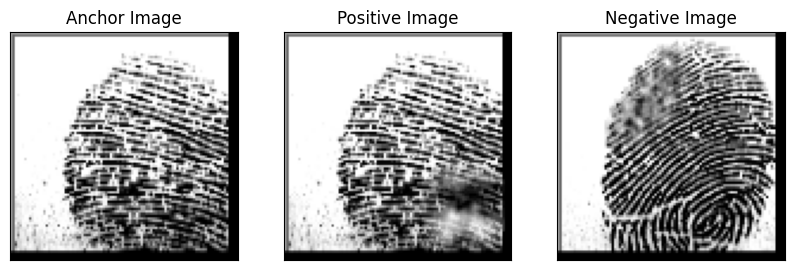

In [ ]:
compute_distance()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_dataset(dataset, model, steps):
    y_true = []
    y_pred = []
    for _ in range(steps):
        try:
            batch = next(iter(dataset))
            inputs, labels = batch
            predictions = model.predict(inputs, verbose=0)
            binary_preds = (predictions < 0.5).astype(int).flatten()
            y_true.extend(labels.flatten())
            y_pred.extend(binary_preds)
        except StopIteration:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

train_metrics = evaluate_dataset(train_gen, siam_network, 64)
test_metrics = evaluate_dataset(test_gen, siam_network, 64)

print("Training Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

print("\nTesting Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")

Training Metrics:
accuracy: 0.9833984375
f1_score: 0.9836223506743738
precision: 0.970532319391635
recall: 0.9970703125
confusion_matrix: [[ 993   31]
 [   3 1021]]

Testing Metrics:
accuracy: 0.98291015625
f1_score: 0.9831811629024507
precision: 0.967833491012299
recall: 0.9990234375
confusion_matrix: [[ 990   34]
 [   1 1023]]
